# Text-Based Emotion Recognition (DEEP LEARNING)

# 1.0 PROJECT SETUP

## 1.1 Python Version

In [1]:
# Checking Python Version
from platform import python_version

print(python_version())

3.10.15


## 1.2 Installing Requried Libraries

In [ ]:
!pip install numpy==1.26.4 pandas seaborn matplotlib scikit-learn==1.5.2 contractions nltk imblearn xgboost

In [ ]:
!pip install tensorflow==2.10.0 tensorflow-gpu==2.10.0

In [ ]:
pip install protobuf==3.20.*

In [ ]:
!pip list

## 1.3 Importing Dependencies

In [5]:
# Importing Libraries
# System
import os
import sys
import gc
import re
import datetime
import time

# Data Analysis
import numpy as np
import pandas as pd
import pickle
import joblib

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Text Processing
import contractions
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# SMOTE
from imblearn.over_sampling import SMOTE

# Scikit-Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Hyperparameter Tuning
import keras_tuner as kt

# Tensorflow
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Ignore warning 
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

## 1.4 Setting Up GPU

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Check GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.5 Directories

In [5]:
# Models
model_names = [
    "CNN",
    "2-CNN",
    "Bi-LSTM"
]

# Create the project directory
project_dir = "models"
tuner_dir = "keras_tuner"

os.makedirs(project_dir, exist_ok = True)
os.makedirs(tuner_dir, exist_ok = True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok = True)
    # Sub-directories
    os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

# Validate project directory
if os.path.exists(project_dir) and os.path.isdir(project_dir):
    print(f"{project_dir} exists and is a directory.")
    for each_model in model_names:
        model_dir = os.path.join(project_dir, each_model)
        if os.path.exists(model_dir) and os.path.isdir(model_dir):
            print(f"  - {model_dir} exists.")
        else:
            print(f"  - ERROR: {model_dir} does not exist.")
else:
    print(f"ERROR: {project_dir} does not exist or is not a directory.")

# Validate tuner directory
if os.path.exists(tuner_dir) and os.path.isdir(tuner_dir):
    print(f"{tuner_dir} exists and is a directory.")
else:
    print(f"ERROR: {tuner_dir} does not exist or is not a directory.")

models exists and is a directory.
  - models\CNN exists.
  - models\2-CNN exists.
  - models\Bi-LSTM exists.
keras_tuner exists and is a directory.


# 2.0 LOADING DATASET

In [6]:
# Define Dataset Path
data_dir = "../dataset/Text/"

In [7]:
# Training data
train_data = pd.read_csv(os.path.join(data_dir, "train.txt"), 
                         names = ['Text', 'Label'], 
                         delimiter = ';')

# Testing data
test_data = pd.read_csv(os.path.join(data_dir, "test.txt"), 
                        names = ['Text', 'Label'], 
                        delimiter = ';')

# Vaidation data
val_data = pd.read_csv(os.path.join(data_dir, "val.txt"), 
                            names = ['Text', 'Label'], 
                            delimiter = ';')

In [8]:
train_data.shape, test_data.shape, val_data.shape

((16000, 2), (2000, 2), (2000, 2))

## 2.1 Training Set

In [9]:
train_data.head()

,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## 2.2 Testing Set

In [10]:
test_data.head()

,Text,Label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


## 2.3 Validation Set

In [11]:
val_data.head()

,Text,Label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


# 3.0 EXPLORATORY DATA ANALYSIS

In [12]:
# Define a mapping dictionary for label replacement
label_mapping = {
    "joy" : "happy",
    "anger" : "angry",
    "sadness" : "sad",
    "love" : "neutral",
    "fear" : "fear",
    "surprise" : "surprise"
}

## 3.1 Distribution 

In [13]:
# Creating Function to Visualise the Distribution
def plot_label_count(df, title):
    
    label_counts = df['Label'].value_counts()
    light_colors = sns.husl_palette(n_colors = len(label_counts))
    sns.set(style = "whitegrid")
    
    # Figure Size
    plt.figure(figsize = (8, 8))

    # Pie Chart
    plt.pie(label_counts, labels = label_counts.index, autopct = '%1.1f%%', 
            startangle = 140, colors = light_colors)

    # Display Title
    plt.title(title)

    # Show Plot
    plt.show()

### 3.1.1 Training Set

In [14]:
# Replace labels in the Training Set
train_data['Label'] = train_data['Label'].replace(label_mapping)

# Verify the changes
print(train_data['Label'].value_counts())

Label
happy       5362
sad         4666
angry       2159
fear        1937
neutral     1304
surprise     572
Name: count, dtype: int64


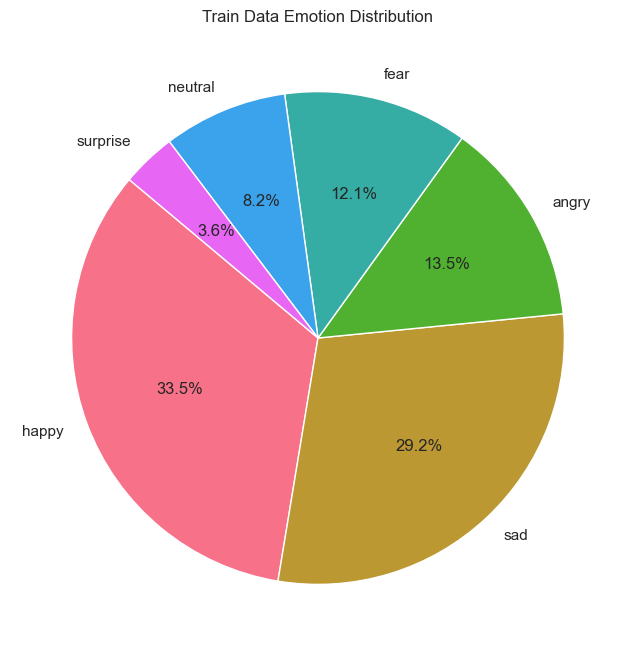

In [15]:
# Pie Chart for Training Set
plot_label_count(train_data, "Train Data Emotion Distribution")

### 3.1.2 Testing Set

In [16]:
# Replace labels in the Testing Set
test_data['Label'] = test_data['Label'].replace(label_mapping)

# Verify the changes
print(test_data['Label'].value_counts())

Label
happy       695
sad         581
angry       275
fear        224
neutral     159
surprise     66
Name: count, dtype: int64


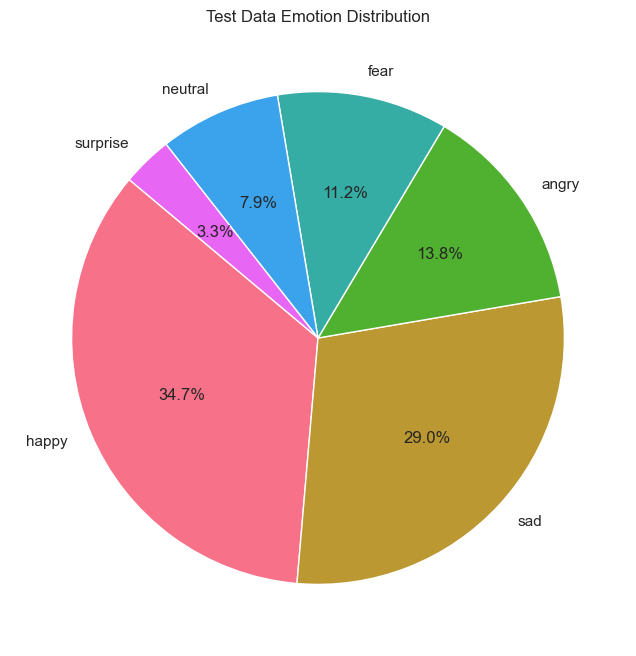

In [17]:
# Pie Chart for Testing Set
plot_label_count(test_data, "Test Data Emotion Distribution")

### 3.1.3 Validation Set

In [18]:
# Replace labels in the Validation Set
val_data['Label'] = val_data['Label'].replace(label_mapping)

# Verify the changes
print(val_data['Label'].value_counts())

Label
happy       704
sad         550
angry       275
fear        212
neutral     178
surprise     81
Name: count, dtype: int64


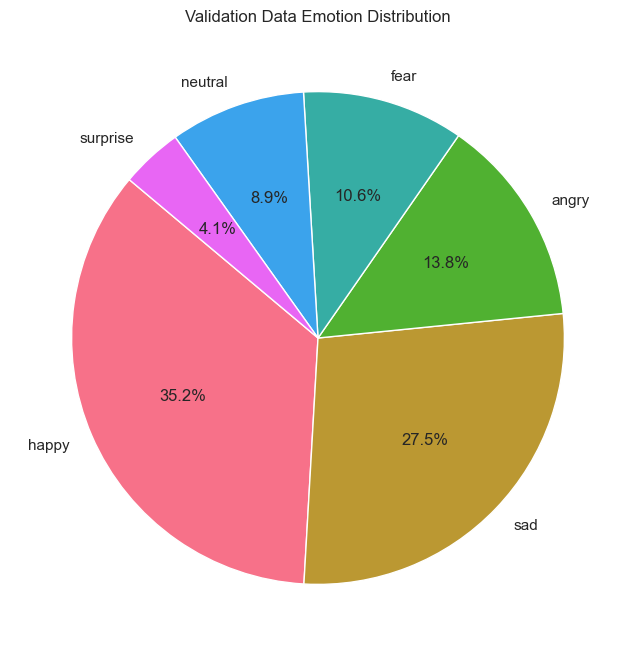

In [19]:
# Pie Chart for Validation Set
plot_label_count(val_data, "Validation Data Emotion Distribution")

## 3.2 Duplication (Same Text and Emotion)

### 3.2.1 Training Set

In [20]:
train_data.duplicated().sum()

1

In [21]:
train_data = train_data.drop_duplicates()

In [22]:
train_data.duplicated().sum()

0

### 3.2.2 Testing Set

In [23]:
test_data.duplicated().sum()

0

### 3.2.3 Validation Set

In [24]:
val_data.duplicated().sum()

0

## 3.3 Duplication (Same Text Different Emotion)

### 3.3.1 Training Set

In [25]:
# Group by the text column and check for duplicates with different labels
duplicates = train_data.groupby('Text')['Label'].nunique()

# Filter for texts with more than one unique label
conflicting_duplicates = duplicates[duplicates > 1].index

# Retrieve the rows with conflicting labels
duplicated_rows = train_data[train_data['Text'].isin(conflicting_duplicates)]

# Display the results
display(duplicated_rows)

,Text,Label
364,i tend to stop breathing when i m feeling stre...,sad
1501,i feel on the verge of tears from weariness i ...,neutral
1625,i was intensely conscious of how much cash i h...,angry
1802,i still feel completely accepted,happy
2908,im still not sure why reilly feels the need to...,fear
2949,i shy away from songs that talk about how i fe...,neutral
3508,i am not amazing or great at photography but i...,happy
4476,i still feel a craving for sweet food,happy
4602,i often find myself feeling assaulted by a mul...,fear
4776,i had to choose the sleek and smoother feel of...,neutral


In [26]:
train_data[train_data['Text'] == train_data.iloc[364]['Text']]

,Text,Label
364,i tend to stop breathing when i m feeling stre...,sad
6563,i tend to stop breathing when i m feeling stre...,angry


In [27]:
# Define label priority
priority = {'happy': 1, 'sad': 2, 'angry': 3, 'neutral': 4, 'fear' : 5, 'surprise' : 6}

# Sort by priority and drop duplicates
train_data['priority'] = train_data['Label'].map(priority)
train_data = train_data.sort_values(by = 'priority').drop_duplicates(subset = 'Text', keep = 'first')

train_data = train_data.drop(columns = ['priority'])  # Remove helper column

In [28]:
# Group by the text column and check for duplicates with different labels
duplicates = train_data.groupby('Text')['Label'].nunique()

# Filter for texts with more than one unique label
conflicting_duplicates = duplicates[duplicates > 1].index

# Retrieve the rows with conflicting labels
duplicated_rows = train_data[train_data['Text'].isin(conflicting_duplicates)]

# Display the results
display(duplicated_rows)

,Text,Label


### 3.3.2 Testing Set

In [29]:
# Group by the text column and check for duplicates with different labels
duplicates = test_data.groupby('Text')['Label'].nunique()

# Filter for texts with more than one unique label
conflicting_duplicates = duplicates[duplicates > 1].index

# Retrieve the rows with conflicting labels
duplicated_rows = test_data[test_data['Text'].isin(conflicting_duplicates)]

# Display the results
display(duplicated_rows)

,Text,Label


### 3.3.3 Validation Set

In [30]:
# Group by the text column and check for duplicates with different labels
duplicates = val_data.groupby('Text')['Label'].nunique()

# Filter for texts with more than one unique label
conflicting_duplicates = duplicates[duplicates > 1].index

# Retrieve the rows with conflicting labels
duplicated_rows = val_data[val_data['Text'].isin(conflicting_duplicates)]

# Display the results
display(duplicated_rows)

,Text,Label
300,i have had several new members tell me how com...,neutral
603,i have had several new members tell me how com...,happy
774,i feel so tortured by it,fear
1993,i feel so tortured by it,angry


In [31]:
# Define label priority
priority = {'happy': 1, 'sad': 2, 'angry': 3, 'neutral': 4, 'fear' : 5, 'surprise' : 6}

# Sort by priority and drop duplicates
val_data['priority'] = val_data['Label'].map(priority)
val_data = val_data.sort_values(by = 'priority').drop_duplicates(subset = 'Text', keep = 'first')

val_data = val_data.drop(columns = ['priority'])  # Remove helper column

In [32]:
# Group by the text column and check for duplicates with different labels
duplicates = val_data.groupby('Text')['Label'].nunique()

# Filter for texts with more than one unique label
conflicting_duplicates = duplicates[duplicates > 1].index

# Retrieve the rows with conflicting labels
duplicated_rows = val_data[val_data['Text'].isin(conflicting_duplicates)]

# Display the results
display(duplicated_rows)

,Text,Label


# 4.0 DATA PRE-PROCESSING

In [33]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [34]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 4.1 Text Preprocessing

In [35]:
# Splitting Text and Labels
X_train = train_data["Text"]
y_train = train_data["Label"]

X_test = test_data["Text"]
y_test = test_data["Label"]

X_val = val_data["Text"]
y_val = val_data["Label"]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(15969,) (15969,)
(2000,) (2000,)
(1998,) (1998,)


In [36]:
# Function to change all text to lowercase
def lower_case(text):
    
    text = text.split()

    text = [y.lower() for y in text]
    
    return " " .join(text)

In [37]:
# Functions to fix text contractions
def fix_contractions(text):

    text = text.split()
    
    text = [contractions.fix(word) for word in text]
    
    return " ".join(text)

In [38]:
# Functions to remove noise from the text data
def remove_noise(text):

    # Ensure the text is a string
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Handle repeated characters (e.g., "soooo" → "so")
    # text = ' '.join([re.sub(r'(.)\1+', r'\1', word) for word in text.split()])

    return text

In [39]:
# Initialising stopwords
stop_words = set(stopwords.words('english') + list(string.punctuation))

# Function to remove stopwords
def remove_stop_words(text):
    
    Text = [i for i in str(text).split() if i not in stop_words]
    
    return " ".join(Text)

In [40]:
# Function for lemmatization
def lemmatization(text):

    # Initialise Lemma
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text = [lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

## 4.2 Applying Pre-Processing

In [41]:
def normalize_text(data):

    # Lower Case
    data.Text = data.Text.apply(lambda text : lower_case(text))
    # Contraction
    data.Text = data.Text.apply(lambda text : fix_contractions(text))
    # Noise
    data.Text = data.Text.apply(lambda text : remove_noise(text))
    # Stop Words
    data.Text = data.Text.apply(lambda text : remove_stop_words(text))
    # Lemma
    data.Text = data.Text.apply(lambda text : lemmatization(text))

    return data

In [42]:
train_data = normalize_text(train_data)
test_data = normalize_text(test_data)
val_data = normalize_text(val_data)

In [43]:
train_data.head()

,Text,Label
7999,still feeling keen whole billy dee lee triangl...,happy
3855,feel peaceful whole situation,happy
3854,feeling amazing mostly normal going pre thanks...,happy
6583,feeling fine november pat bertram href http pt...,happy
6584,tell pretty hundred time mean feel pretty,happy


In [44]:
test_data.head()

,Text,Label
0,feeling rather rotten ambitious right,sad
1,updating blog feel shitty,sad
2,never make separate ever want feel like ashamed,sad
3,left bouquet red yellow tulip arm feeling slig...,happy
4,feeling little vain one,sad


In [45]:
 val_data.head()

,Text,Label
1999,feel like want buy cute make see online even one,happy
590,always feel triumphant recycling bin brimming ...,happy
1353,feel like kind cute,happy
1346,feel stumble class content link href plusone,happy
1340,feel thrilled whole experience,happy


## 4.3 Label Encoding

In [46]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [47]:
print("Encoded Classes:", le.classes_)

Encoded Classes: ['angry' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [48]:
print(y_train)

[2 2 2 ... 5 5 5]


In [49]:
print(y_test)

[4 4 4 ... 2 2 1]


In [50]:
print(y_val)

[2 2 2 ... 5 5 5]


In [51]:
# Save the LabelEncoder
with open('label_encoder.pkl', 'wb') as file:
    joblib.dump(le, file)

print("Label Encoder Saved Successfully")

Label Encoder Saved Successfully


## 4.4 One-Hot Encoding

In [52]:
# Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [53]:
print(y_train)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [54]:
print(y_test)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [55]:
print(y_val)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


## 4.5 Tokenization

In [56]:
# Tokenize words
tokenizer = Tokenizer(oov_token = 'UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis = 0))

In [57]:
tokenizer.document_count

17969

In [58]:
tokenizer.word_index['towards']

322

In [59]:
tokenizer.texts_to_sequences(X_train[0].split())

[[2], [139], [3], [649]]

In [60]:
tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [61]:
tokenizer.texts_to_matrix(X_train[0].split()).shape

(4, 16186)

In [62]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [63]:
#print the sentence after converting them to indexes
sequences_train

[[16,
  72,
  26,
  8,
  96,
  946,
  30,
  6,
  250,
  2657,
  5615,
  3277,
  5616,
  191,
  1814,
  32,
  37,
  16,
  2942,
  58,
  30,
  6,
  250,
  3277,
  7928,
  191,
  20,
  1814,
  118,
  37,
  2,
  418,
  41,
  1279,
  226,
  9,
  5615,
  99,
  141,
  735,
  1730,
  12,
  3277,
  298,
  2453,
  3759],
 [2, 3, 46, 651, 27, 6, 250, 488],
 [2,
  24,
  8,
  258,
  998,
  786,
  2,
  24,
  87,
  5,
  7,
  2281,
  1668,
  3278,
  25,
  134,
  176,
  60,
  9,
  52,
  83,
  130,
  12,
  5617],
 [2, 24, 8, 386, 2658, 4464, 7929, 7, 208, 189, 7930],
 [2, 215, 51, 2, 24, 103, 7, 2943, 200, 827, 43, 310, 2, 3, 103],
 [2,
  3,
  6,
  5618,
  92,
  225,
  6,
  1173,
  77,
  1174,
  7931,
  7932,
  2,
  24,
  38,
  1530,
  12,
  126,
  7933,
  30,
  60,
  6,
  1669,
  1305,
  12,
  11,
  1345,
  2659,
  4465],
 [2,
  3,
  14,
  111,
  130,
  103,
  632,
  152,
  764,
  2,
  5619,
  980,
  102,
  30,
  6,
  263,
  29,
  981],
 [2,
  100,
  43,
  48,
  53,
  2,
  67,
  12,
  11,
  78,
  33,
 

In [64]:
with open("tokenizer.pkl", "wb") as f:
    joblib.dump(tokenizer, f)

print("Tokenizer Saved Successfully")

Tokenizer Saved Successfully


## 4.6 Padding

In [65]:
test_data.shape

(2000, 2)

In [66]:
maxlen = max([len(t) for t in test_data['Text']])
maxlen

218

In [67]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16186


In [68]:
#before
sequences_train[0]

[16,
 72,
 26,
 8,
 96,
 946,
 30,
 6,
 250,
 2657,
 5615,
 3277,
 5616,
 191,
 1814,
 32,
 37,
 16,
 2942,
 58,
 30,
 6,
 250,
 3277,
 7928,
 191,
 20,
 1814,
 118,
 37,
 2,
 418,
 41,
 1279,
 226,
 9,
 5615,
 99,
 141,
 735,
 1730,
 12,
 3277,
 298,
 2453,
 3759]

In [69]:
#after
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## 4.7 Word Embedding

In [67]:
# Read GloVE embeddings
path_to_glove_file = os.path.join(data_dir, "glove.6B.200d.txt")

In [68]:
# Defining parameters
class emb_parms:
    NUM_TOKENS = vocabSize
    EMBEDDING_INDEX = {}
    EMBEDDING_DIM = 200
    HITS = 0
    MISSES = 0

In [69]:
# Read word vectors
with open(path_to_glove_file, encoding = "utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit = 1)
        coefs = np.fromstring(coefs, "f", sep = " ")
        emb_parms.EMBEDDING_INDEX[word] = coefs

print("Found %s word vectors." % len(emb_parms.EMBEDDING_INDEX))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((emb_parms.NUM_TOKENS, emb_parms.EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = emb_parms.EMBEDDING_INDEX.get(word)
    
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        emb_parms.HITS += 1
    else:
        emb_parms.MISSES += 1

# Print the output    
print("Converted %d words (%d misses)" % (emb_parms.HITS, emb_parms.MISSES))

Found 400000 word vectors.
Converted 15069 words (1116 misses)


## 5.0 MODELLING

In [70]:
# Save Model Checkpoint
def get_checkpoint_callback(model_path, model_name):
    
    # Create a directory for saving checkpoints
    model_name = model_name
    chk_point_dir = os.path.join(model_path, "checkpoints")
    os.makedirs(chk_point_dir, exist_ok = True)

    # Add a timestamp for uniqueness
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    filepath = os.path.join(chk_point_dir, f"{model_name}_{timestamp}_checkpoint.h5")

    # Return a ModelCheckpoint callback with the generated filepath
    return ModelCheckpoint(
        filepath = filepath,
        save_best_only = True,
        verbose = 1,
        mode = "max",
        monitor = "val_accuracy"
)

# Early Stopping
early_stopping = EarlyStopping(
    restore_best_weights = "True",
    min_delta = 0,  # Min change in the monitored quantity to qualify as an improvement
    patience = 10,  # Number of epochs with no improvement
    verbose = 1, 
    mode = "max",
    monitor = "val_accuracy"
)

# RLRP
rlrp = ReduceLROnPlateau(
    factor = 0.2,  # Factor by which LR will be reduced
    patience = 5,
    verbose = 1,
    min_delta = 0.0001,  # Threshold for measuring the new optimum
    mode = "auto",
    monitor = "val_accuracy"
)

In [71]:
class cfg:
    INPUT_VOCAB = vocabSize
    INPUT_SHAPE = X_train.shape[1]
    OUTPUT_DIM = 200
    BATCH_SIZE = 64
    EPOCHS = 100
    NUM_CLASSES = 6

## 5.1 Baseline CNN

In [72]:
# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

In [73]:
# Define Neurons
L1 = 128
L2 = 64

# Building CNN Model
baseline_cnn = tf.keras.Sequential([
    
    # Embedding layer
    L.Embedding(input_dim = cfg.INPUT_VOCAB, output_dim = cfg.OUTPUT_DIM, input_length = cfg.INPUT_SHAPE,
               weights = [embedding_matrix], trainable = False),

    # Convolutional Layer
    L.Conv1D(filters = L1, kernel_size = 5, activation = "relu",
            kernel_initializer = "HeNormal",
            kernel_regularizer = tf.keras.regularizers.l2(0.01)),

    # Max-Pooling Layer
    L.MaxPooling1D(pool_size = 2),

    # Flatten 
    L.Flatten(),
    L.Dense(L2, activation =  "relu",
           kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    L.Dropout(0.5), # Dropout to prevent overfitting

    # Output Layer
    L.Dense(cfg.NUM_CLASSES, activation = "softmax")
])

# Model Summary
baseline_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 229, 200)          3237200   
                                                                 
 conv1d (Conv1D)             (None, 225, 128)          128128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 112, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 14336)             0         
                                                                 
 dense (Dense)               (None, 64)                917568    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [74]:
# Define Model Path
model_name = "CNN"
model_path = os.path.join("models", model_name)

# Define Checkpoint Path
chk_point = get_checkpoint_callback(model_path, model_name)

# Define CSV Path
csv_logger = CSVLogger(os.path.join(model_path, "logs/training_log.csv"))

In [75]:
baseline_cnn.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [76]:
# Defining callbacks
callbacks = [chk_point, early_stopping, rlrp, csv_logger]

# Saving Model History
baseline_cnn_history = baseline_cnn.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    batch_size = cfg.BATCH_SIZE,
    epochs = cfg.EPOCHS,
    callbacks = callbacks
)

Epoch 1/100
246/250 [============================>.] - ETA: 0s - loss: 2.0433 - accuracy: 0.4106
Epoch 1: val_accuracy improved from -inf to 0.51852, saving model to models\CNN\checkpoints\CNN_20241223-003316_checkpoint.h5
250/250 [==============================] - 9s 9ms/step - loss: 2.0361 - accuracy: 0.4114 - val_loss: 1.4450 - val_accuracy: 0.5185 - lr: 0.0010
Epoch 2/100
247/250 [============================>.] - ETA: 0s - loss: 1.4691 - accuracy: 0.5030
Epoch 2: val_accuracy improved from 0.51852 to 0.53854, saving model to models\CNN\checkpoints\CNN_20241223-003316_checkpoint.h5
250/250 [==============================] - 2s 8ms/step - loss: 1.4693 - accuracy: 0.5028 - val_loss: 1.3750 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 3/100
244/250 [============================>.] - ETA: 0s - loss: 1.4038 - accuracy: 0.5213
Epoch 3: val_accuracy improved from 0.53854 to 0.56907, saving model to models\CNN\checkpoints\CNN_20241223-003316_checkpoint.h5
250/250 [============================

## 5.2 Two-Branch Baseline CNN

In [77]:
# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

In [78]:
# Define Neurons
L1 = 128
L2 = 64

# Building Branch 1: Smaller N-Grams (Local Features)
branch1_input = L.Input(shape = (cfg.INPUT_SHAPE,))

branch1 = L.Embedding(input_dim = cfg.INPUT_VOCAB, output_dim = cfg.OUTPUT_DIM, input_length = cfg.INPUT_SHAPE,
                      weights = [embedding_matrix], trainable = False)(branch1_input)

branch1 = L.Conv1D(filters = L1, kernel_size = 3, activation = "relu",
                   kernel_initializer = "HeNormal",
                   kernel_regularizer = tf.keras.regularizers.l2(0.01))(branch1)

branch1 = L.MaxPooling1D(pool_size=2)(branch1)

branch1 = L.Flatten()(branch1)

# Building Branch 2: Larger N-Grams (Global Features)
branch2_input = L.Input(shape = (cfg.INPUT_SHAPE,))

branch2 = L.Embedding(input_dim = cfg.INPUT_VOCAB, output_dim = cfg.OUTPUT_DIM, input_length = cfg.INPUT_SHAPE,
                      weights = [embedding_matrix], trainable = False)(branch2_input)

branch2 = L.Conv1D(filters = L1, kernel_size = 5, activation = "relu",
                   kernel_initializer = "HeNormal",
                   kernel_regularizer = tf.keras.regularizers.l2(0.01))(branch2)

branch2 = L.MaxPooling1D(pool_size = 2)(branch2)

branch2 = L.Flatten()(branch2)

# Concatenate Outputs
merged = L.Concatenate()([branch1, branch2])

# Fully Connected Layer
dense = L.Dense(L2, activation = "relu",
                kernel_regularizer = tf.keras.regularizers.l2(0.01))(merged)
dropout = L.Dropout(0.5)(dense)

# Output Layer
output = L.Dense(cfg.NUM_CLASSES, activation = "softmax")(dropout)

# Define Model
baseline_two_cnn = tf.keras.Model(inputs = [branch1_input, branch2_input], outputs = output)

# Model Summary
baseline_two_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 229)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 229)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 229, 200)     3237200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 229, 200)     3237200     ['input_2[0][0]']                
                                                                                              

In [80]:
# Define Model Path
model_name = "2-CNN"
model_path = os.path.join("models", model_name)

# Define Checkpoint Path
chk_point = get_checkpoint_callback(model_path, model_name)

# Define CSV Path
csv_logger = CSVLogger(os.path.join(model_path, "logs/training_log.csv"))

In [81]:
baseline_two_cnn.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [82]:
X_train_branch1 = X_train  # For branch 1
X_train_branch2 = X_train  # For branch 2
X_val_branch1 = X_val      # For branch 1
X_val_branch2 = X_val      # For branch 2

In [83]:
# Defining callbacks
callbacks = [chk_point, early_stopping, rlrp, csv_logger]

# Saving Model History
baseline_two_cnn_history = baseline_two_cnn.fit(
    [X_train_branch1, X_train_branch2], y_train,
    validation_data = ([X_val_branch1, X_val_branch2], y_val),
    batch_size = cfg.BATCH_SIZE,
    epochs = cfg.EPOCHS,
    callbacks = callbacks
)

Epoch 1/100
247/250 [============================>.] - ETA: 0s - loss: 2.4305 - accuracy: 0.3820
Epoch 1: val_accuracy improved from -inf to 0.50501, saving model to models\2-CNN\checkpoints\2-CNN_20241223-003555_checkpoint.h5
250/250 [==============================] - 3s 12ms/step - loss: 2.4219 - accuracy: 0.3825 - val_loss: 1.5051 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 1.4881 - accuracy: 0.4863
Epoch 2: val_accuracy improved from 0.50501 to 0.52953, saving model to models\2-CNN\checkpoints\2-CNN_20241223-003555_checkpoint.h5
250/250 [==============================] - 3s 11ms/step - loss: 1.4881 - accuracy: 0.4863 - val_loss: 1.3993 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.4422 - accuracy: 0.5013
Epoch 3: val_accuracy improved from 0.52953 to 0.53604, saving model to models\2-CNN\checkpoints\2-CNN_20241223-003555_checkpoint.h5
250/250 [==============

## 5.3 Baseline Bi-LSTM

In [72]:
# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

In [73]:
# Define Neurons
L1 = 256
L2 = 128

# Input Layer
inputs = tf.keras.Input(shape=(cfg.INPUT_SHAPE,))

# Embedding Layer
embedding = L.Embedding(cfg.INPUT_VOCAB, 200, input_length=cfg.INPUT_SHAPE, weights=[embedding_matrix], trainable=False)(inputs)

# Bi-LSTM Layers
lstm1 = L.Bidirectional(L.LSTM(L1, dropout=0.3, recurrent_dropout=0, return_sequences=True))(embedding)
lstm2 = L.Bidirectional(L.LSTM(L2, dropout=0.3, recurrent_dropout=0, return_sequences=True))(lstm1)

# Attention Layer
attention_output = L.Attention()([lstm2, lstm2])  # Self-attention using the same tensor for query and value

# Global Max Pooling
global_max_pool = L.GlobalMaxPooling1D()(attention_output)

# Fully Connected Layers
dense1 = L.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(global_max_pool)
dropout1 = L.Dropout(0.4)(dense1)
dense2 = L.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout1)
dropout2 = L.Dropout(0.4)(dense2)

# Output Layer
outputs = L.Dense(cfg.NUM_CLASSES, activation='softmax')(dropout2)

# Define the Model
baseline_bi_lstm = tf.keras.Model(inputs=inputs, outputs=outputs)

# Model Summary
baseline_bi_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 229)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 229, 200)     3237200     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 229, 512)     935936      ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 229, 256)    656384      ['bidirectional[0][0]']          
 )                                                                                            

In [74]:
# Define Model Path
model_name = "Bi-LSTM"
model_path = os.path.join("models", model_name)

# Define Checkpoint Path
chk_point = get_checkpoint_callback(model_path, model_name)

# Define CSV Path
csv_logger = CSVLogger(os.path.join(model_path, "logs/training_log.csv"))

In [75]:
baseline_bi_lstm.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [76]:
# Defining callbacks
callbacks = [chk_point, early_stopping, rlrp, csv_logger]

# Saving Model History
bi_lstm_history = baseline_bi_lstm.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    batch_size = cfg.BATCH_SIZE,
    epochs = cfg.EPOCHS,
    callbacks = callbacks
)

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 2.3121 - accuracy: 0.4185
Epoch 1: val_accuracy improved from -inf to 0.53804, saving model to models\Bi-LSTM\checkpoints\Bi-LSTM_20241223-203901_checkpoint.h5
250/250 [==============================] - 32s 99ms/step - loss: 2.3121 - accuracy: 0.4185 - val_loss: 1.3647 - val_accuracy: 0.5380 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 1.2095 - accuracy: 0.5635
Epoch 2: val_accuracy improved from 0.53804 to 0.66366, saving model to models\Bi-LSTM\checkpoints\Bi-LSTM_20241223-203901_checkpoint.h5
250/250 [==============================] - 22s 90ms/step - loss: 1.2095 - accuracy: 0.5635 - val_loss: 0.8828 - val_accuracy: 0.6637 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 0.8135 - accuracy: 0.7029
Epoch 3: val_accuracy improved from 0.66366 to 0.82883, saving model to models\Bi-LSTM\checkpoints\Bi-LSTM_20241223-203901_checkpoint.h5
250/250 [

# 6.0 HYPERPARAMETER TUNING

In [77]:
# Early Stopping
early_stopping = EarlyStopping(
    restore_best_weights = "True",
    min_delta = 0,  # Min change in the monitored quantity to qualify as an improvement
    patience = 10,  # Number of epochs with no improvement
    verbose = 1, 
    mode = "max",
    monitor = "val_accuracy"
)

# RLRP
rlrp = ReduceLROnPlateau(
    factor = 0.2,  # Factor by which LR will be reduced
    patience = 5,
    verbose = 1,
    min_delta = 0.0001,  # Threshold for measuring the new optimum
    mode = "auto",
    monitor = "val_accuracy"
)

In [81]:
def build_bi_lstm_model(hp):
    # Input Layer
    inputs = tf.keras.Input(shape=(cfg.INPUT_SHAPE,))
    
    # Embedding Layer
    embedding_dim = hp.Int("embedding_dim", min_value = 50, max_value = 300, step = 50)
    resized_embedding_matrix = embedding_matrix[:, :embedding_dim]  # Adjust to match embedding_dim
    embedding = L.Embedding(input_dim=cfg.INPUT_VOCAB,output_dim=embedding_dim,input_length=cfg.INPUT_SHAPE,weights=[resized_embedding_matrix],trainable=hp.Boolean("trainable_embedding"))(inputs)

    # LSTM Layers
    x = embedding
    for i in range(hp.Int("num_lstm_layers", 1, 3)):
        lstm_units = hp.Int(f"lstm_units_{i}", min_value = 64, max_value = 512, step = 64)
        x = L.Bidirectional(L.LSTM(lstm_units, dropout = hp.Float("dropout_rate", 0.1, 0.5, step = 0.1), 
                                    return_sequences = True))(x)
    
    # Optional Attention Layer
    if hp.Boolean("use_attention"):
        x = L.Attention()([x, x])

    # Global Pooling and Dense Layers
    x = L.GlobalMaxPooling1D()(x)
    x = L.Dense(256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(hp.Float("l2_lambda", 1e-5, 1e-2, sampling = "log")))(x)
    x = L.Dropout(hp.Float("dropout_rate", 0.1, 0.5, step = 0.1))(x)
    x = L.Dense(128, activation='relu')(x)
    outputs = L.Dense(cfg.NUM_CLASSES, activation = 'softmax')(x)

    # Compile Model
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    optimizer = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [82]:
tuner = kt.BayesianOptimization(
    hypermodel = build_bi_lstm_model,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 1,
    overwrite = True,
    directory = "./keras_tuner",
    project_name = "TER_BASE_BI_LSTM_TUNE",
    seed = 33
)

In [83]:
tuner.search(
    X_train, y_train,
    epochs = cfg.EPOCHS,
    batch_size = cfg.BATCH_SIZE,
    validation_data = (X_val, y_val), 
    callbacks = [early_stopping, rlrp]
)

Trial 10 Complete [00h 00m 02s]

Best val_accuracy So Far: 0.9454454183578491
Total elapsed time: 04h 31m 25s


In [84]:
best_bi_lstm_model = tuner.get_best_models()[0]
best_bi_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 229)]             0         
                                                                 
 embedding (Embedding)       (None, 229, 150)          2427900   
                                                                 
 bidirectional (Bidirectiona  (None, 229, 640)         1205760   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 229, 640)         2460160   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 229, 128)         360960    
 nal)                                                            
                                                             

In [85]:
best_bi_lstm_hp = tuner.get_best_hyperparameters(num_trials = 1)
best_bi_lstm_hp = best_bi_lstm_hp[0]
best_bi_lstm_hp.values

{'embedding_dim': 150,
 'trainable_embedding': False,
 'num_lstm_layers': 3,
 'lstm_units_0': 320,
 'dropout_rate': 0.5,
 'use_attention': False,
 'l2_lambda': 0.007902373711581125,
 'optimizer': 'adam',
 'lstm_units_1': 320,
 'lstm_units_2': 64}

In [86]:
best_bi_lstm_history = best_bi_lstm_model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    batch_size = cfg.BATCH_SIZE,
    epochs = cfg.EPOCHS,
    callbacks = callbacks
)

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9584
Epoch 1: val_accuracy did not improve from 0.94444
250/250 [==============================] - 63s 213ms/step - loss: 0.0936 - accuracy: 0.9584 - val_loss: 0.1203 - val_accuracy: 0.9409 - lr: 4.0000e-05
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9568
Epoch 2: val_accuracy did not improve from 0.94444
250/250 [==============================] - 53s 210ms/step - loss: 0.0934 - accuracy: 0.9568 - val_loss: 0.1200 - val_accuracy: 0.9434 - lr: 4.0000e-05
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 0.0917 - accuracy: 0.9597
Epoch 3: val_accuracy did not improve from 0.94444
250/250 [==============================] - 51s 202ms/step - loss: 0.0917 - accuracy: 0.9597 - val_loss: 0.1223 - val_accuracy: 0.9434 - lr: 4.0000e-05
Epoch 4/100
250/250 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9590
Epoch 

# 7.0 MODEL EVALUATION

In [87]:
def plot_model_history(history):

    fig, axs = plt.subplots(1, 2, figsize = (15, 5))

    # Summarise History for Accuracy
    axs[0].plot(history.history["accuracy"])
    axs[0].plot(history.history["val_accuracy"])
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].legend(["train", "validate"], loc = "upper left")

    # Summarise History for Loss
    axs[1].plot(history.history["loss"])
    axs[1].plot(history.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(["train", "validate"], loc = "upper left")

    # Display Plot
    plt.show()

In [88]:
def evaluate_model(model):

    # Evaluate on training data
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 1)

    # Evaluate on testing data
    test_loss, test_acc = model.evaluate(X_val, y_val, verbose = 1)

    # Print results
    print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc * 100, test_acc * 100))

In [89]:
def plot_confusion_matrix(model):
    
    # Get true classes
    true_classes = np.argmax(y_val, axis = 1) if len(y_val.shape) > 1 else y_val
    
    # Get predicted classes
    y_pred = model.predict(X_val)
    predicted_classes = np.argmax(y_pred, axis = 1)

    # Class Labels
    class_labels = {'happy' : 1, 'angry' : 2, 'sad' : 3, 'neutral' : 4, 'fear' : 5, 'surprise' : 6}
    class_labels = list(class_labels.keys())
    
    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    # Plot confusion matrix
    plt.figure(figsize = (10, 8))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [90]:
def print_classification_report(model):
   
    # Get true classes
    true_classes = np.argmax(y_val, axis = 1) if len(y_val.shape) > 1 else y_val
    
    # Get predicted classes
    y_pred = model.predict(X_val)
    predicted_classes = np.argmax(y_pred, axis = 1)

    # Class Labels
    class_labels = {'happy' : 1, 'angry' : 2, 'sad' : 3, 'neutral' : 4, 'fear' : 5, 'surprise' : 6}
    class_labels = list(class_labels.keys())
    
    # Generate classification report
    report = classification_report(true_classes, predicted_classes, target_names = class_labels)
    
    # Print the classification report
    print("Classification Report:\n", report)

## 7.1 Baseline CNN

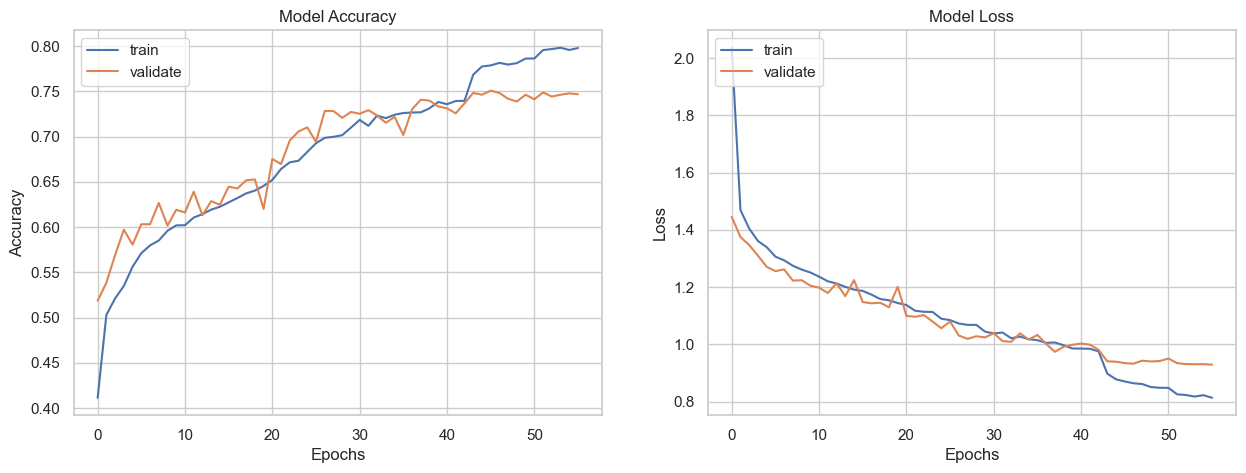

In [118]:
plot_model_history(baseline_cnn_history)

In [137]:
evaluate_model(baseline_cnn)

63/63 [==============================] - 0s 5ms/step - loss: 0.9346 - accuracy: 0.7508
final train accuracy = 82.98 , validation accuracy = 75.08


63/63 [==============================] - 0s 2ms/step


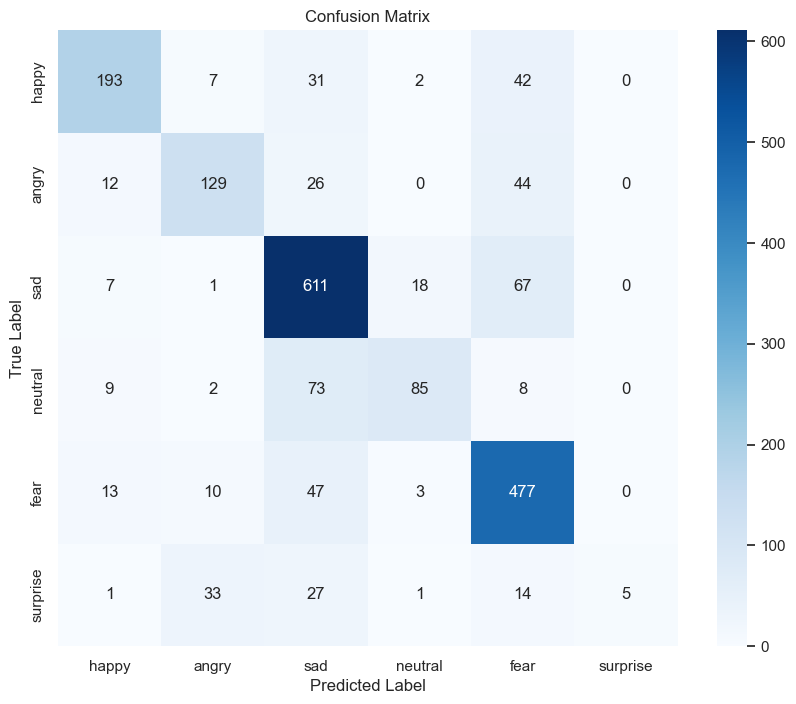

In [132]:
plot_confusion_matrix(baseline_cnn)

In [134]:
print_classification_report(baseline_cnn)

63/63 [==============================] - 0s 5ms/step
Classification Report:
               precision    recall  f1-score   support

       happy       0.82      0.70      0.76       275
       angry       0.71      0.61      0.66       211
         sad       0.75      0.87      0.80       704
     neutral       0.78      0.48      0.59       177
        fear       0.73      0.87      0.79       550
    surprise       1.00      0.06      0.12        81

    accuracy                           0.75      1998
   macro avg       0.80      0.60      0.62      1998
weighted avg       0.76      0.75      0.73      1998



## 7.2 Baseline 2-Branch CNN

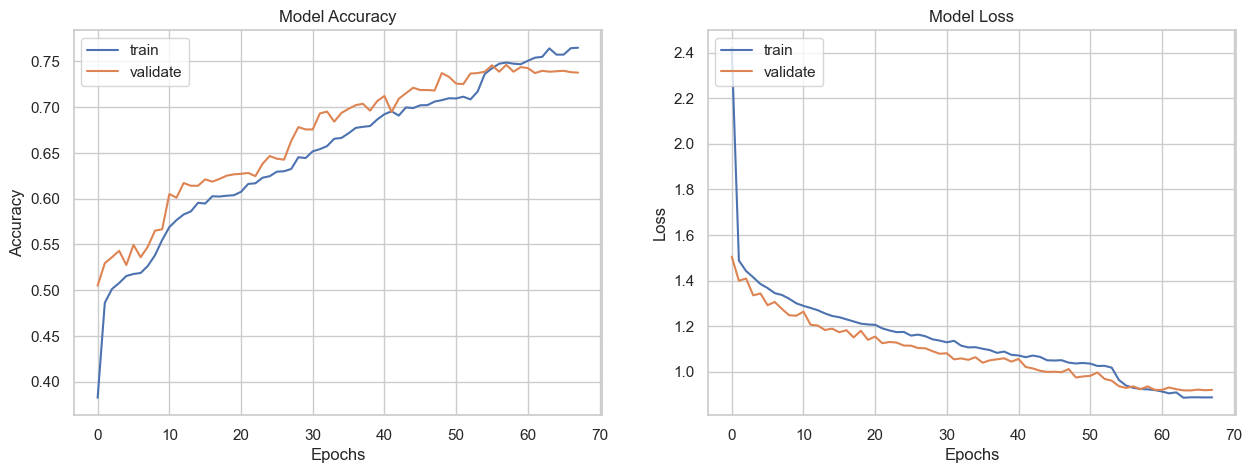

In [135]:
plot_model_history(baseline_two_cnn_history)

## 7.3 Baseline Bi-LSTM

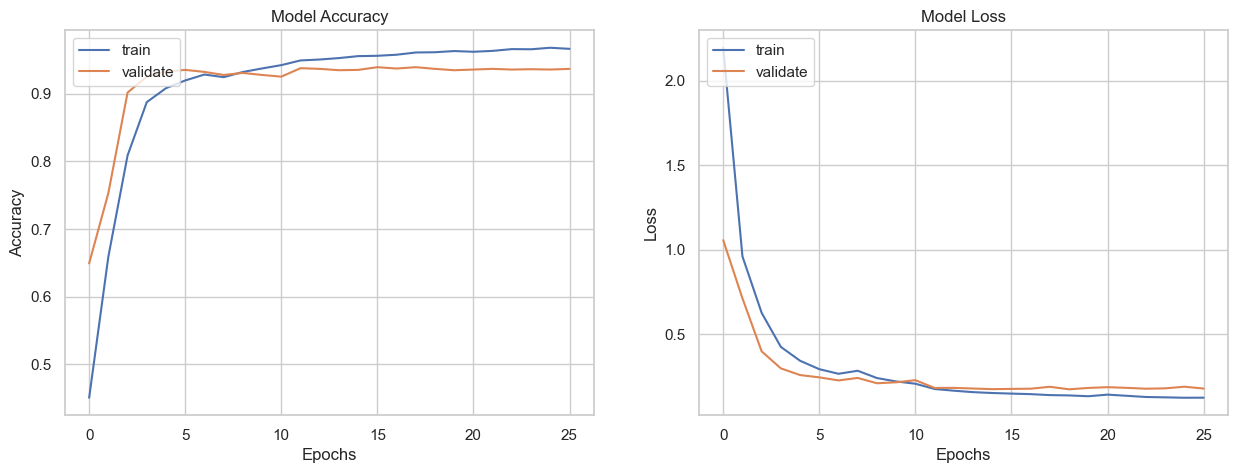

In [124]:
plot_model_history(bi_lstm_history)

In [139]:
evaluate_model(baseline_bi_lstm)

63/63 [==============================] - 4s 58ms/step - loss: 0.1753 - accuracy: 0.9394
final train accuracy = 97.06 , validation accuracy = 93.94


63/63 [==============================] - 5s 56ms/step


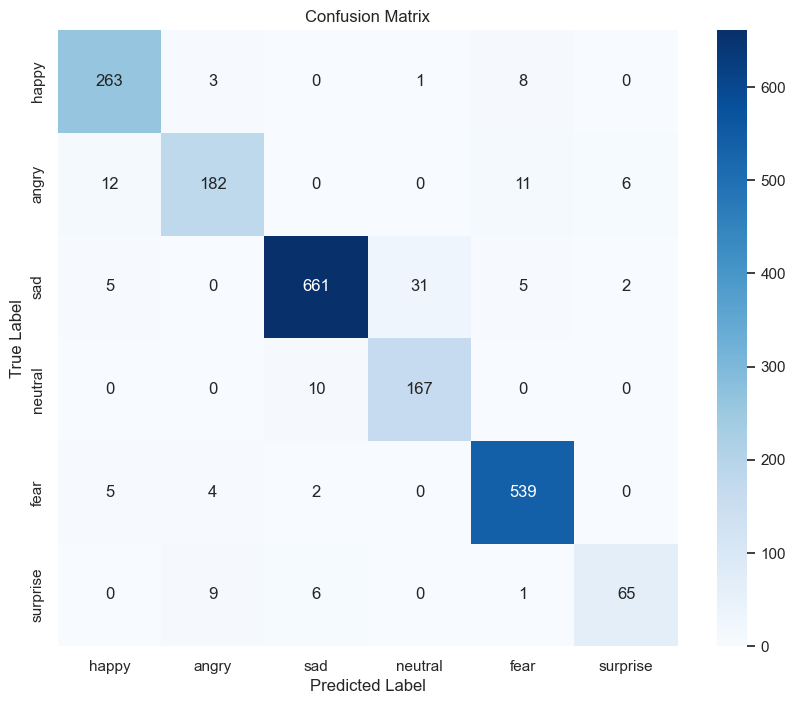

In [142]:
plot_confusion_matrix(baseline_bi_lstm)

In [145]:
print_classification_report(baseline_bi_lstm)

63/63 [==============================] - 4s 58ms/step
Classification Report:
               precision    recall  f1-score   support

       happy       0.92      0.96      0.94       275
       angry       0.92      0.86      0.89       211
         sad       0.97      0.94      0.96       704
     neutral       0.84      0.94      0.89       177
        fear       0.96      0.98      0.97       550
    surprise       0.89      0.80      0.84        81

    accuracy                           0.94      1998
   macro avg       0.92      0.91      0.91      1998
weighted avg       0.94      0.94      0.94      1998



## 7.4 Tunned Bi-LSTM

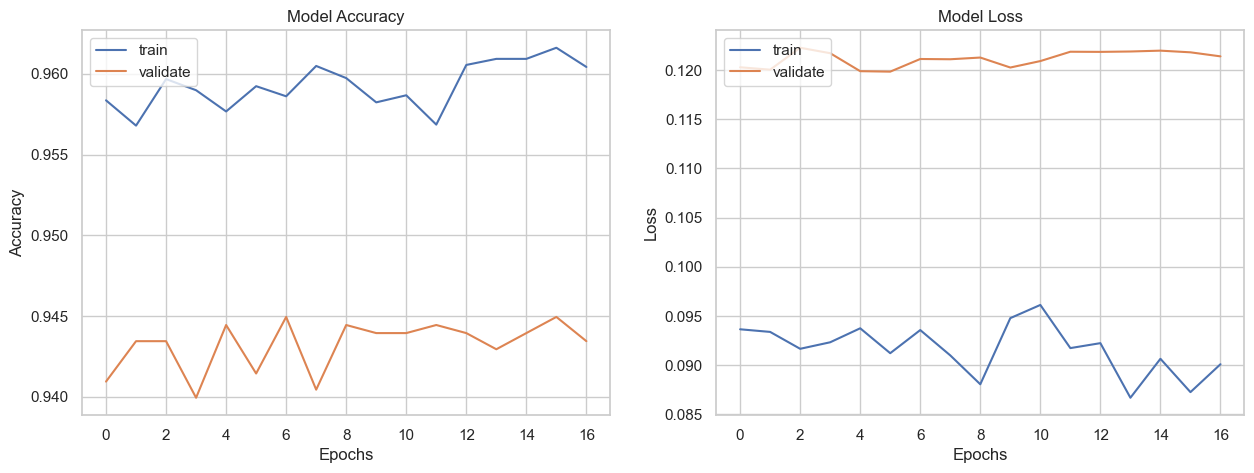

In [91]:
plot_model_history(best_bi_lstm_history)

In [92]:
evaluate_model(best_bi_lstm_model)

63/63 [==============================] - 5s 83ms/step - loss: 0.1211 - accuracy: 0.9449
final train accuracy = 97.20 , validation accuracy = 94.49


63/63 [==============================] - 9s 108ms/step


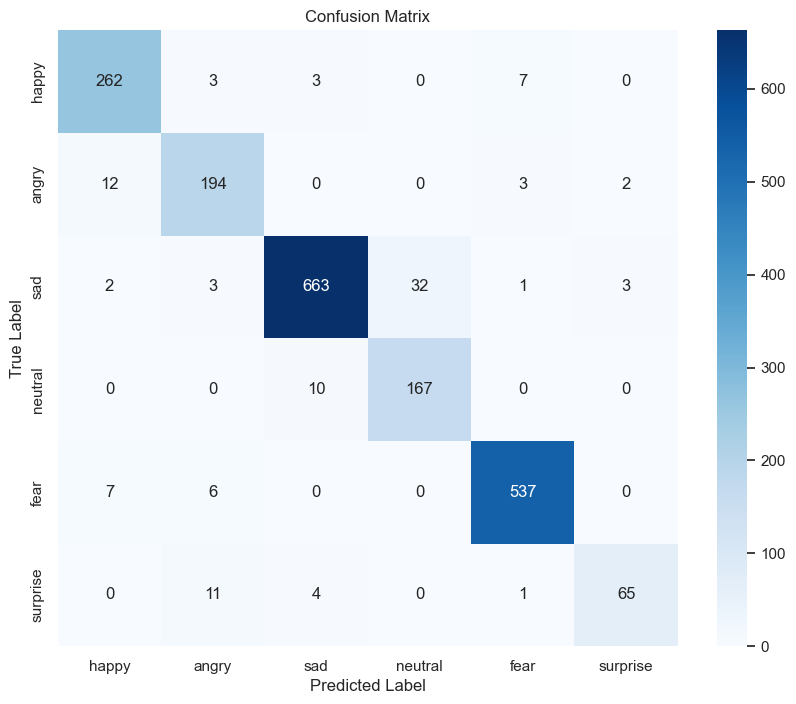

In [93]:
plot_confusion_matrix(best_bi_lstm_model)

In [94]:
print_classification_report(best_bi_lstm_model)

63/63 [==============================] - 6s 93ms/step
Classification Report:
               precision    recall  f1-score   support

       happy       0.93      0.95      0.94       275
       angry       0.89      0.92      0.91       211
         sad       0.97      0.94      0.96       704
     neutral       0.84      0.94      0.89       177
        fear       0.98      0.98      0.98       550
    surprise       0.93      0.80      0.86        81

    accuracy                           0.94      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.95      0.94      0.95      1998



In [95]:
# Define Model Path
model_name = "Bi-LSTM"
model_path = os.path.join("models", model_name)
saved_model = os.path.join(model_path, "saved_models")

# Save Model
best_bi_lstm_model.save(os.path.join(saved_model, "Best_Bi_LSTM.h5"))
print("Best Bi-LSTM Model Saved")

Best Bi-LSTM Model Saved


# 8.0 EVALUATING ON TEST SET

In [96]:
from tensorflow.keras.models import load_model

In [97]:
# Define Model Path
model_path = "models/Bi-LSTM/saved_models/Best_Bi_LSTM.h5"

# Load Model
model = load_model(model_path)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print results
print("Test Accuracy: {:.2f}".format(test_acc * 100))

63/63 [==============================] - 7s 76ms/step - loss: 0.1534 - accuracy: 0.9255
Test Accuracy: 92.55


# 9.0 EVALUATING ON OWN TEXT

In [1]:
def predict(text):
    
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    import joblib
    from tensorflow.keras.models import load_model

    # Define Paths
    model_path = "models/Bi-LSTM/saved_models/Best_Bi_LSTM.h5"
    token_path = "tokenizer.pkl"
    label_path = "label_encoder.pkl"

    
    # Load Model
    model = load_model(model_path, compile = False)
    
    # Load Tokenizer
    with open(token_path, 'rb') as f:
        tokenizer = joblib.load(f)

    # Load Labels
    with open(label_path, 'rb') as file:
        le = joblib.load(file)

    
    # Tokenize and Padding
    sequence = tokenizer.texts_to_sequences([text])
    maxlen = 229
    padding_sequence = pad_sequences(sequence, maxlen = maxlen, truncating = 'pre')
    
    # Prediction
    prediction = model(padding_sequence, training = False)
    emotion = le.inverse_transform([prediction.numpy().argmax()])[0]

    # Visualisation
    labels = le.classes_ # Get all class labels
    probs = prediction.numpy()[0] # Get probabilities for each class
    
    plt.figure(figsize = (10, 6))
    bars = plt.barh(labels, probs, color = 'skyblue')
    plt.xlabel('Probability', fontsize = 12)
    plt.ylabel('Emotion', fontsize = 12)
    plt.title('Emotion Prediction', fontsize = 15)
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    
    for bar, prob in zip(bars, probs):
        plt.gca().text(
            bar.get_width() + 0.01,  # Position text slightly to the right of the bar
            bar.get_y() + bar.get_height() / 2,
            f"{prob:.2f}",  # Format probability with 2 decimal places
            va = 'center', fontsize = 10
        )
        
    plt.show()

    return emotion

## 9.1 Test Case 1

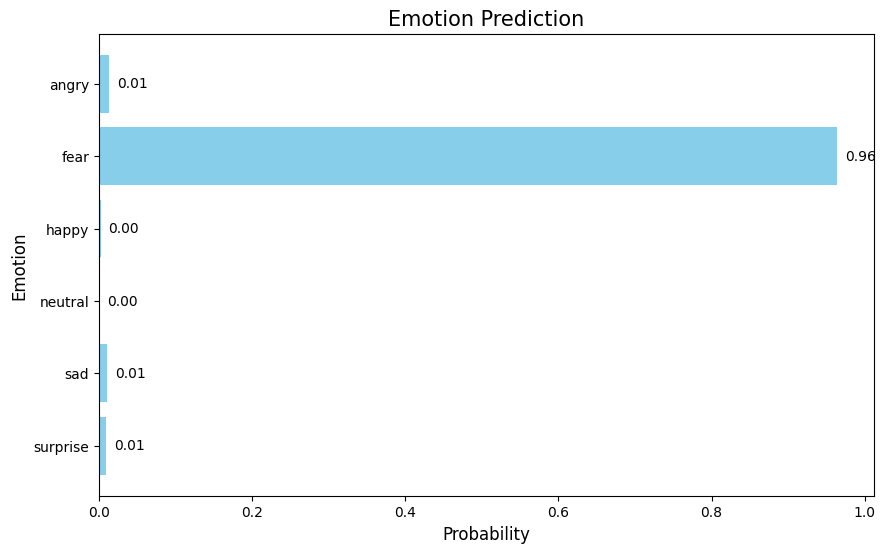

Predicted Emotion: fear


In [2]:
# Test Case 1
text = """
The air was thick with silence, the kind that made every breath feel like a scream. As Alex crept down the dimly lit hallway, 
shadows twisted unnaturally along the walls. A faint whisper echoed behind him, though he was alone. His pulse pounded, 
and his hands trembled as he reached for the door handle. Just as his fingers brushed the cold metal, it jerked violently. 
His heart nearly stopped. A chilling voice rasped from the other side, "I've been waiting for you." The lights flickered,
and darkness swallowed him whole.
"""

# Prediction
emotion = predict(text)
print(f"Predicted Emotion: {emotion}")

## Test Case 2

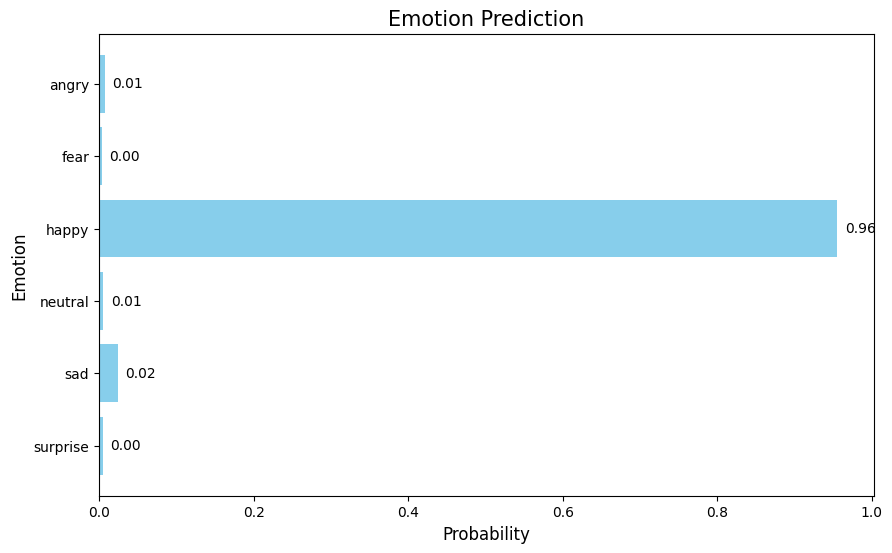

Predicted Emotion: happy


In [3]:
text = """
Oh, what a fantastic day! First, I spilled coffee on my white shirt—because who doesn’t love a spontaneous tie-dye moment? 
Then, I got stuck in traffic for an hour, enjoying the delightful symphony of honking horns. 
And just when I thought life couldn’t get any better, my phone died right before an important call. 
Truly, the universe is working overtime to make sure I have the best time ever.
Honestly, I don’t know how I manage to handle so much luck in one day.
"""
# Prediction
emotion = predict(text)
print(f"Predicted Emotion: {emotion}")

## 9.2 Test Case 3

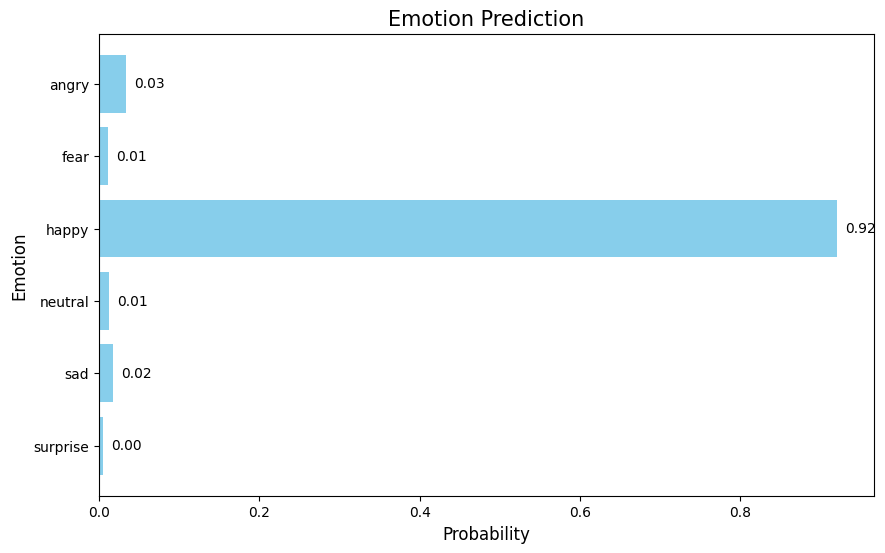

Predicted Emotion: happy


In [4]:
text = """
She'd take the world off my shoulders if it was ever hard to move. 
She'd turn the rain to a rainbow when I was living in the blue. 
Why then, if she's so perfect, do I still wish that it was you? 
Perfect don't mean that it's working, so what can I do? 
When you're out of sight in my mind. 
Cause sometimes I look in her eyes, and that's where I find a glimpse of us. 
And I try to fall for her touch, but I'm thinking of the way it was. 
Said, "I'm fine" and said, "I moved on" I'm only here passing time in her arms. 
Hoping I'll find a glimpse of us.
"""
# Prediction
emotion = predict(text)
print(f"Predicted Emotion: {emotion}")